p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Thur v.s. Fri: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=6.305e+02
Thur v.s. Sat: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.407e-01 U_stat=2.180e+03
Sun v.s. Fri: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=8.041e-02 U_stat=9.605e+02


(<Axes: xlabel='day', ylabel='total_bill'>,
  <statannot.StatResult.StatResult at 0x17cb0a050>])

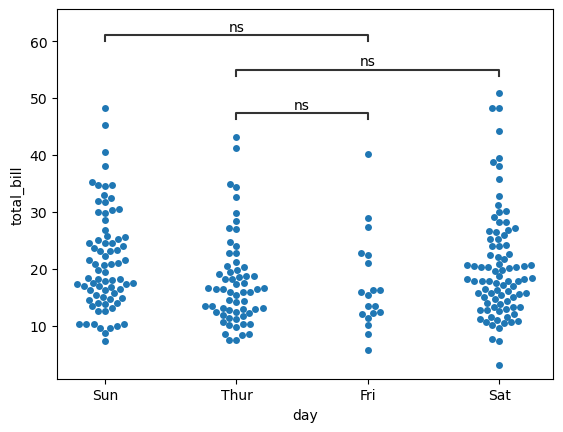

In [10]:
import seaborn as sns
from statannot import add_stat_annotation

df = sns.load_dataset("tips")
x = "day"
y = "total_bill"
order = ['Sun', 'Thur', 'Fri', 'Sat']
ax = sns.swarmplot(data=df, x=x, y=y, order=order)

test_results = add_stat_annotation(ax, data=df, x=x, y=y, order=order,
                                   box_pairs=[("Thur", "Fri"), ("Thur", "Sat"), ("Fri", "Sun")],
                                   test='Mann-Whitney', text_format='star',
                                   loc='inside', verbose=2)
test_results

In [6]:
df = pd.read_csv('../data/221026_recheck-miseq-triplicates/barseq_counts.csv')

# normalize read count
sample_list = ['1','2','3','4','5','6']
for sample in sample_list:
    df[f'{sample}_norm'] = df[sample]/df[sample].sum()

# fold change
for t0,t1 in zip([1,2,3],[4,5,6]):
    df[f'fold_change_{t0}'] = df[f'{t1}_norm'] / df[f'{t0}_norm']
    
df['pkr'] = df['var'].str.split('_').str[0]
df['k3l'] = df['var'].str.split('_').str[1]

# down-select for K3L-NULL and K3L-WT
def k3l_type(row, k3l_stop=88):
    x = row['k3l'].split('-')[1]
    if x == 'WT':
        return 'K3L-WT'
    elif x[-1] == '*' and int(x[1:-1]) < k3l_stop:
        return 'K3L-STOP' 
    else:
        return 'K3L-VAR'
    
df['k3l_type'] = df.apply(lambda x: k3l_type(x), axis=1)

# select for only pairs to K3L-WT
df1 = df.query('k3l == "K3L-WT"')

pkr_resistant_vars = ['E375V','I378T', 'R382I', 'I405M', 'S448G', 'M455V', 'A473T', 'E480D', 'D486V', 'T491S', 'S504L', 'E524V']
def pkr_type(x, pkr_stop = 550):
    if x[-1] == "*" and int(x.split('-')[1][1:-1]) < pkr_stop:
        return "STOP"
    elif x[-2:] == 'WT':
        return "WT"
    elif x.split('-')[1] in pkr_resistant_vars:
        return "Resistant"
    else:
        return 'Variant'
df1['pkr_type'] = df1['pkr'].apply(pkr_type)

df1['mean_fold_change'] = df1[['fold_change_1','fold_change_2','fold_change_3']].mean(axis=1)

# take only measures with >10 reads at TP-0
df1['tp0_read_mean'] = df1[['1','2','3']].mean(axis=1)
df2 = df1.query('tp0_read_mean >= 10').melt(['pkr', 'pkr_type'], 'mean_fold_change')

variant_map = {'WT':'WT','STOP':'Nonsense', 'Resistant':'Known Improved Variant', 'Variant':'Missense Variant'}
df2['pkr_type'] = df2.pkr_type.map(variant_map)

/var/folders/fq/q1cflf795cgbnmbhdyn8d9nntyw5jt/T/ipykernel_67109/2314630763.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['pkr_type'] = df1['pkr'].apply(pkr_type)
/var/folders/fq/q1cflf795cgbnmbhdyn8d9nntyw5jt/T/ipykernel_67109/2314630763.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['mean_fold_change'] = df1[['fold_change_1','fold_change_2','fold_change_3']].mean(axis=1)
/var/folders/fq/q1cflf795cgbnmbhdyn8d9nntyw5jt/T/ipykernel_67109/2314630763.py:45: SettingWithCopyWarning: 
A value

In [7]:
# plot
output_file = '../img/pkr_data-figure/2.3_pkr-regions-swarmplot.svg'

plt.rcParams['savefig.dpi'] = 300
plt.rcParams["figure.figsize"] = (6,4)

# swarmplot
color_dict = {'WT':"#1DA5E4",'Nonsense':'#F92321',"Known Improved Variant":"#242AD9","Missense Variant":'gray'}

g = sns.swarmplot(
    x='pkr_regions',
    y='value', 
    hue='pkr_type', 
    data=df4,
    palette = color_dict,
    order=['Region 1','Region 2','Region 3', 'Region 4']
    #hue_order=['Resistant','STOP','Variant']
)
g.invert_yaxis()

g.axhline(0.958688, color='#6dc091', linestyle='--', linewidth=4) # pkr-wt , old1 0.928775, old2 0.966365

#g.get_legend().remove()
#g.spines["left"].set_visible(False)

g.set_yscale("log", base=2)
g.set_ylim(bottom=2, top=.5)


# plot the mean line
sns.boxplot(
    showmeans=True,
    meanline=True,
    meanprops={'color': 'k', 'ls': '-', 'lw': 2},
    medianprops={'visible': False},
    whiskerprops={'visible': False},
    zorder=10,
    x="pkr_regions",
    y="value",
    data=df4,
    showfliers=False,
    showbox=False,
    showcaps=False,
    order=['Region 1','Region 2','Region 3', 'Region 4'],
    ax=g
)

g.set_ylabel('Log2 Fold Change')
g.set_xlabel('')

legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='Missense Variant', markerfacecolor='gray', markersize=10),
    Line2D([0], [0], marker='o', color='w', label='Known Improved Variant', markerfacecolor='#242AD9', markersize=10),
    Line2D([0], [0], marker='o', color='w', label='Nonsense Variant', markerfacecolor='#F92321', markersize=10),
    Line2D([0], [0], color='#6dc091', lw=2, label='WT PKR', linestyle='--'),
    Line2D([0], [0], color='black', lw=2, label='Mean Log2 Fold Change', linestyle='-'),

]

g.legend(title='PKR Variant Types', handles=legend_elements,bbox_to_anchor=(1.0, 1.0), loc='upper left')
#plt.legend(bbox_to_anchor=(1.0, 1.0), loc='upper left')

test_results = add_stat_annotation(g, data=df4, x='pkr_regions', y='value', order=['Region 1','Region 2','Region 3', 'Region 4'],
                                   box_pairs=[("Region 1", "Region 3"), ("Region 2","Region 3"),("Region 3", "Region 4")],
                                   test='Mann-Whitney', text_format='star',
                                   loc='outside', verbose=2)
test_results
plt.tight_layout()

#fig = g.get_figure()
#fig.savefig(output_file, bbox_inches='tight')

,pkr,pkr_type,variable,value
0,PKR-WT,WT,mean_fold_change,0.958688
1,PKR-F278L,Missense Variant,mean_fold_change,1.320132
2,PKR-M455I,Missense Variant,mean_fold_change,0.989696
3,PKR-Y454*,Nonsense,mean_fold_change,1.378280
4,PKR-E384D,Missense Variant,mean_fold_change,0.990818
...,...,...,...,...
401,PKR-S448A,Missense Variant,mean_fold_change,1.382137
402,PKR-I420T,Missense Variant,mean_fold_change,1.048707
403,PKR-F267I,Missense Variant,mean_fold_change,1.456898
404,PKR-I503L,Missense Variant,mean_fold_change,1.813361


In [8]:
df2.pkr_type.unique()

array(['WT', 'Missense Variant', 'Nonsense', 'Known Improved Variant'],
      dtype=object)

<Axes: ylabel='value'>

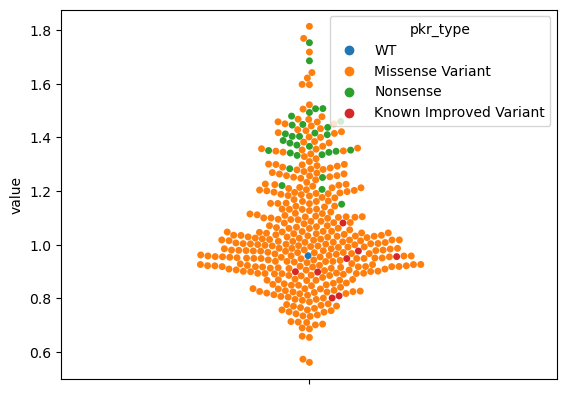

In [9]:
sns.swarmplot(data=df2, y='value', hue='pkr_type', hue_order=['WT', 'Missense Variant', 'Nonsense', 'Known Improved Variant'])